# Домашнее задание 2. StarGAN

## Этап 1. Установка зависимостей, инициализация и загрузка данных

В этом разделе мы работаем с датасетом CelebA, содержащим изображения лиц с набором атрибутов. Целью задания является генерация новых изображений лиц с заданными характеристиками.

# ВНИМАНИЕ:

Веса лежат на моем диске (ссылка = https://disk.yandex.ru/d/H7MbdHjgtbiyXw) есть веса для всех 4 эпох моего обучения

Скачайте сначала только 4 эпоху, потом будем загружать для валидации ниже

In [1]:
MODEL_PATH = 'checkpoint_epoch_4.pt'

In [2]:
# !pip install lpips -q
# !pip3.11 uninstall datasets
# !pip3.11 install gdown

In [3]:
!ls

02_hw_StarGAN-new-Copy1.ipynb checkpoint_epoch_3.pt
02_hw_StarGAN-new.ipynb       checkpoint_epoch_4.pt
02_hw_StarGAN.ipynb           checkpoints
checkpoint_epoch_1.pt         data
checkpoint_epoch_10.pt        data.zip
checkpoint_epoch_2.pt         data1


In [4]:
# %pip install lpips -q

import sys

# тут надо добавить путь 
# sys.path.append('../../seminars/utils/')  # Добавляем путь к CelebADataset
sys.path.append('data/')  # Добавляем путь к CelebADataset

import torch
import time
import os
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import os
import torch.optim as optim
from lpips import LPIPS
from torchvision import transforms
from munch import Munch
from tqdm.auto import trange
import matplotlib.pyplot as plt
from data.celeba import CelebADataset
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import math
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device)

Может быть загрузка не произойдет, из-за ограниченного доступа к загрузке датасета, но у меня при обучении срабатывал

Пожалуйста, убедитесь, что данные будут загружены

In [5]:
# import gdown
# import os
# import zipfile

# os.makedirs("data/celeba", exist_ok=True)
# os.chdir("data/celeba")

# print("Downloading img_align_celeba.zip...")
# gdown.download(id='1_2glEieyMJt8O8IgtlsQEgCX-ZYbvKMm', output='img_align_celeba.zip', quiet=False)

# print("Downloading annotation files...")
# gdown.download(id='1XDTGJ2-QNMvkIdFwlvYAO28uc9v2d9PO', output='list_attr_celeba.txt', quiet=False)
# gdown.download(id='1V6zDszhMCokTZTh4EZ48RB9wslY_YSCl', output='list_eval_partition.txt', quiet=False)

# # Unzip the images
# print("Unzipping images...")
# with zipfile.ZipFile('img_align_celeba.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

# # Clean up the zip file
# os.remove('img_align_celeba.zip')

# print("Download and extraction complete!")
# os.chdir("../..")

In [6]:
args = Munch()
args.img_size = 256  # Размер изображений после преобразования

# Создание последовательности преобразований для подготовки изображений
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Загрузка датасета CelebA с применением указанных преобразований

# данные должны лежать в root_dir, если нет перезапустите и раскоментируйте код выше
dataset = CelebADataset(
    root_dir='data/celeba',
    transform=transform)

# здесь выбираем 15 аттрибутов, чтобы ускорить обучение и
# также желательно искать такие аттрибуты, чтобы можно было понятно
# генерить изображения и следить за обучением

selected_attrs = [
    'Male', 'Young', 'Smiling', 'Eyeglasses', 'Wearing_Hat',
    'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair',
    'Brown_Hair', 'Big_Nose', 'Heavy_Makeup', 'Goatee', 'Chubby'
]

selected_indices = [dataset.header.index(attr) for attr in selected_attrs]
args.num_domains = len(selected_attrs)

class SubsetCelebA(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices  # список индексов выбранных атрибутов

    def __getitem__(self, idx):
        img, meta = self.dataset[idx]
        attrs = meta['attributes'][self.indices]  # тензор выбранных атрибутов
        return img, attrs

    def __len__(self):
        return len(self.dataset)

dataset = SubsetCelebA(dataset, selected_indices)

# Число потоков для загрузки данных
num_workers = 0 if device.type == 'cuda' or device.type == 'mps'  else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' or device.type == 'mps' else False

# args.batch_size = ...   # Задайте размер батча
args.batch_size = 16

# Создание DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

In [7]:
# args.num_domains = ...  # Задайте число доменов
# args.num_domains = len(dataset.header) 

### Визуализация датасета

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


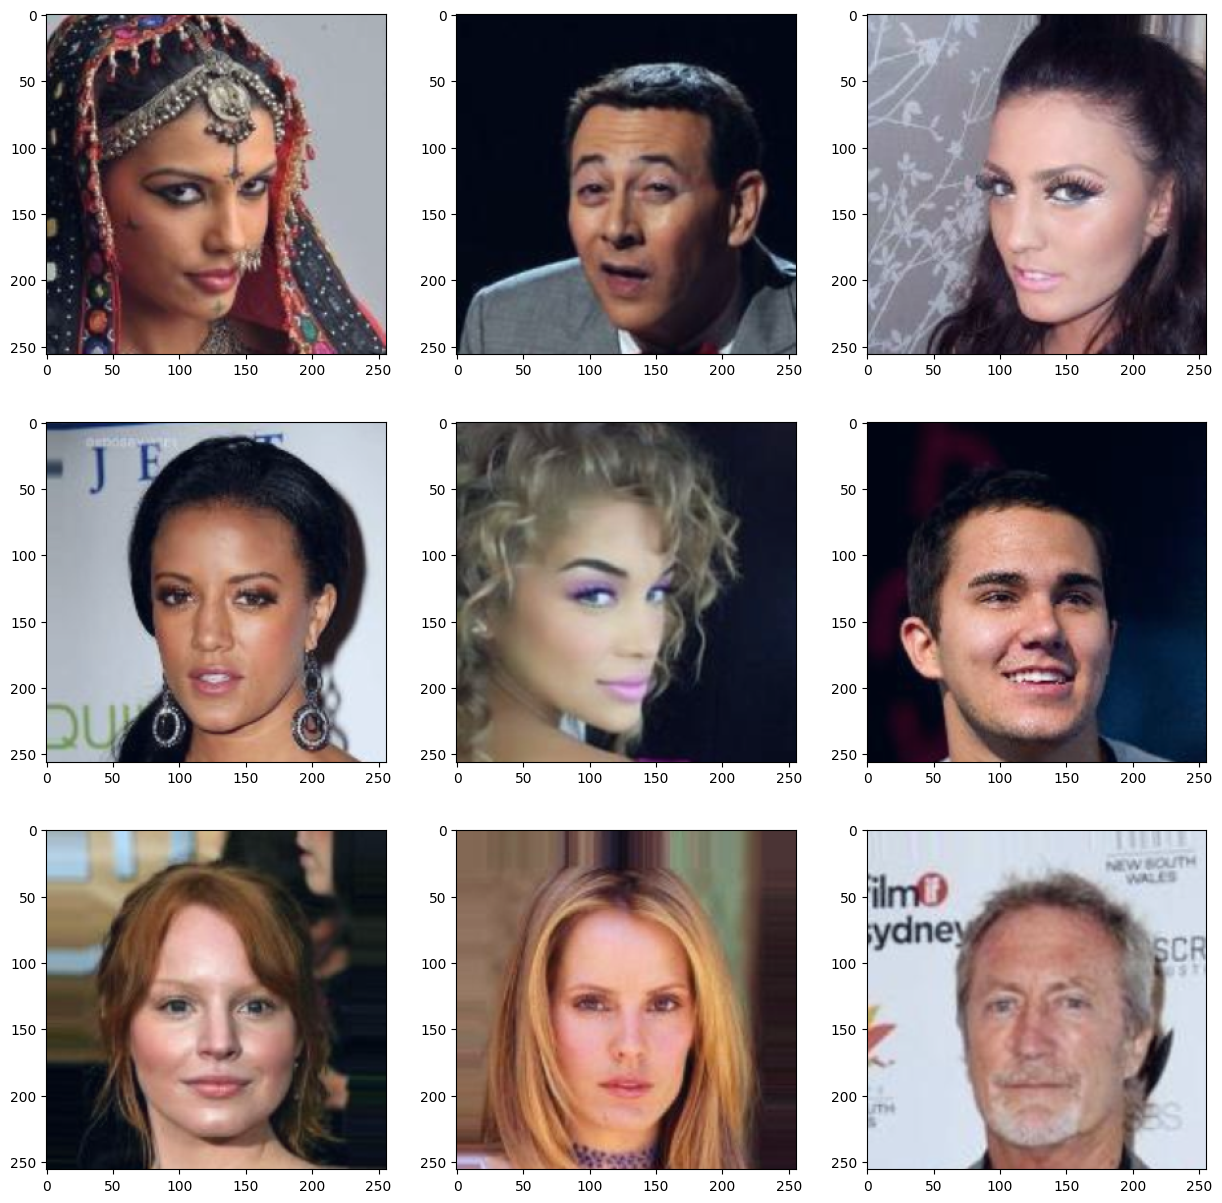

In [8]:
# Визуализация случайно выбранных изображений из датасета

_, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), 9)):

    img, target = dataset[img_idx]
    print(img.shape)
    img = (img - img.min()) / (img.max() - img.min())
    axes[i // 3][i % 3].imshow(img.detach().cpu().numpy().transpose(1, 2, 0))

## Этап 2. Инициализация и обучение модели

В этом этапе необходимо реализовать и обучить модель StarGAN для генерации лиц с заданными атрибутами.

Вы можете выбрать одну из следующих моделей:
- [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**)
- [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

### Инициализация

Ниже приведён шаблон для определения основных компонентов модели. Реализуйте их по своему усмотрению.

Мы будем реализовывать StarGANv2, поэтому инициализируем некоторые дополнительные блоки из оригиналной статьи (AdaIN)

In [9]:
args.latent_dim = 16
args.style_dim = 32
args.w_hpf = 0
args.lr = 1e-4
args.beta1, args.beta2 = 0.0, 0.99
args.weight_decay = 0.0

args.lambda_reg = 1.0
args.lambda_sty = 1.0
args.lambda_ds  = 1.0
args.lambda_cyc = 1.0
args.ds_iter = 5000


# AdaIN и ResBlk были взяты очень схожие из оригинального кода StarGANv2
class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, actv=nn.LeakyReLU(0.2), normalize=False, downsample=False):
        super().__init__()
        self.actv = actv
        self.normalize = normalize
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out

        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2)


class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features * 2)

    def forward(self, x, s):
        h = self.fc(s).view(s.size(0), -1, 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta


class AdainResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=32, actv=nn.LeakyReLU(0.2), upsample=False):
        super().__init__()
        self.actv = actv
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out

        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        out = (self._residual(x, s) + self._shortcut(x)) / math.sqrt(2)
        return out


class Generator(nn.Module):
    def __init__(self, img_size=256, style_dim=32, max_conv_dim=256):
        super().__init__()
        dim_in = 2**14 // img_size
        self.from_rgb = nn.Conv2d(3, dim_in, 3, 1, 1)

        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()

        self.to_rgb = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 3, 1, 1, 0),
        )

        repeat_num = int(np.log2(img_size)) - 4
        for _ in range(repeat_num):
            dim_out = min(dim_in * 2, max_conv_dim)
            self.encode.append(ResBlk(dim_in, dim_out, normalize=True, downsample=True))
            self.decode.insert(0, AdainResBlk(dim_out, dim_in, style_dim, upsample=True))
            dim_in = dim_out

        for _ in range(2):
            self.encode.append(ResBlk(dim_in, dim_in, normalize=True))
            self.decode.insert(0, AdainResBlk(dim_in, dim_in, style_dim))

    def forward(self, x, s):
        x = self.from_rgb(x)
        for block in self.encode:
            x = block(x)
        for block in self.decode:
            x = block(x, s)
        return self.to_rgb(x)


class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=32, num_domains=15):
        super().__init__()
        layers = [nn.Linear(latent_dim, 512), nn.ReLU()]
        for _ in range(3):
            layers += [nn.Linear(512, 512), nn.ReLU()]
        self.shared = nn.Sequential(*layers)

        self.unshared = nn.ModuleList([
            nn.Sequential(
                nn.Linear(512, 512), nn.ReLU(),
                nn.Linear(512, 512), nn.ReLU(),
                nn.Linear(512, 512), nn.ReLU(),
                nn.Linear(512, style_dim)
            )
            for _ in range(num_domains)
        ])

    def forward(self, z, y):
        h = self.shared(z)
        out = torch.stack([layer(h) for layer in self.unshared], dim=1)
        idx = torch.arange(y.size(0), device=y.device)
        return out[idx, y]


class StyleEncoder(nn.Module):
    def __init__(self, img_size=256, style_dim=32, num_domains=15, max_conv_dim=256):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = [nn.Conv2d(3, dim_in, 3, 1, 1)]
        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in * 2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out
        blocks += [nn.LeakyReLU(0.2), nn.Conv2d(dim_in, dim_in, 4, 1, 0), nn.LeakyReLU(0.2)]
        self.shared = nn.Sequential(*blocks)

        self.unshared = nn.ModuleList([nn.Linear(dim_in, style_dim) for _ in range(num_domains)])

    def forward(self, x, y):
        h = self.shared(x).view(x.size(0), -1)
        out = torch.stack([layer(h) for layer in self.unshared], dim=1)
        idx = torch.arange(y.size(0), device=y.device)
        return out[idx, y]


class Discriminator(nn.Module):
    def __init__(self, img_size=256, num_domains=15, max_conv_dim=256):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = [nn.Conv2d(3, dim_in, 3, 1, 1)]
        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in * 2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out
        blocks += [
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, dim_in, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, num_domains, 1, 1, 0),
        ]
        self.main = nn.Sequential(*blocks)

    def forward(self, x, y):
        out = self.main(x).view(x.size(0), -1)
        idx = torch.arange(y.size(0), device=y.device)
        return out[idx, y]

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

nets = Munch()
nets.generator = Generator(args.img_size, args.style_dim, max_conv_dim=256).to(device)
nets.mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains).to(device)
nets.style_encoder = StyleEncoder(args.img_size, args.style_dim, args.num_domains, max_conv_dim=256).to(device)
nets.discriminator = Discriminator(args.img_size, args.num_domains, max_conv_dim=256).to(device)

nets.generator.apply(weights_init)
nets.mapping_network.apply(weights_init)
nets.style_encoder.apply(weights_init)
nets.discriminator.apply(weights_init)

nets_ema = Munch(
    generator=deepcopy(nets.generator).eval(),
    mapping_network=deepcopy(nets.mapping_network).eval(),
    style_encoder=deepcopy(nets.style_encoder).eval(),
)

optims = Munch()
optims.generator = torch.optim.Adam(nets.generator.parameters(), lr=args.lr, betas=(args.beta1, args.beta2))
optims.mapping_network = torch.optim.Adam(nets.mapping_network.parameters(), lr=args.lr * 0.01, betas=(args.beta1, args.beta2))
optims.style_encoder = torch.optim.Adam(nets.style_encoder.parameters(), lr=args.lr, betas=(args.beta1, args.beta2))
optims.discriminator = torch.optim.Adam(nets.discriminator.parameters(), lr=args.lr, betas=(args.beta1, args.beta2))

### Обучение

In [11]:
def adv_loss(logits, target: int):
    targets = torch.full_like(logits, fill_value=float(target))
    return F.binary_cross_entropy_with_logits(logits, targets)

def r1_reg(d_out, x_in):
    grad = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    return 0.5 * grad.float().pow(2).view(x_in.size(0), -1).sum(1).mean()

@torch.no_grad()
def moving_average(model, model_ema, beta=0.999):
    for p, p_ema in zip(model.parameters(), model_ema.parameters()):
        p_ema.data = torch.lerp(p.data, p_ema.data, beta)

def compute_d_loss(nets, x_real, y_org, y_trg, z_trg=None, x_ref=None, calc_reg=False):
    assert (z_trg is None) != (x_ref is None)
    
    x_real.requires_grad_()
    out_real = nets.discriminator(x_real, y_org)
    loss_real = adv_loss(out_real, 1)
    
    loss_reg = 0.0
    if calc_reg:
        loss_reg = r1_reg(out_real, x_real)
        
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg)
        else:
            s_trg = nets.style_encoder(x_ref, y_trg)
        x_fake = nets.generator(x_real, s_trg)
        
    out_fake = nets.discriminator(x_fake, y_trg)
    loss_fake = adv_loss(out_fake, 0)
    
    reg_weight = args.lambda_reg * 16 if calc_reg else 0.0
    loss = loss_real + loss_fake + reg_weight * loss_reg
    
    reg_val = loss_reg.item() if calc_reg else 0.0
    return loss, dict(real=loss_real.item(), fake=loss_fake.item(), reg=reg_val)

def compute_g_loss(nets, x_real, y_org, y_trg, z_trgs=None, x_refs=None):
    assert (z_trgs is None) != (x_refs is None)

    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
        s_trg  = nets.mapping_network(z_trg, y_trg)
        s_trg2 = nets.mapping_network(z_trg2, y_trg)
    else:
        x_ref, x_ref2 = x_refs
        s_trg  = nets.style_encoder(x_ref, y_trg)
        s_trg2 = nets.style_encoder(x_ref2, y_trg)

    x_fake = nets.generator(x_real, s_trg)
    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = (s_pred - s_trg).abs().mean()

    x_fake2 = nets.generator(x_real, s_trg2).detach()
    loss_ds = (x_fake - x_fake2).abs().mean()

    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org)
    loss_cyc = (x_rec - x_real).abs().mean()

    loss = loss_adv + args.lambda_sty * loss_sty - args.lambda_ds * loss_ds + args.lambda_cyc * loss_cyc
    return loss, dict(adv=loss_adv.item(), sty=loss_sty.item(), ds=loss_ds.item(), cyc=loss_cyc.item())

In [12]:
import os

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_g_loss = float("inf")

def save_checkpoint(epoch, nets, nets_ema, optims, best_g_loss, filename):
    torch.save({
        "epoch": epoch,
        "generator": nets.generator.state_dict(),
        "mapping_network": nets.mapping_network.state_dict(),
        "style_encoder": nets.style_encoder.state_dict(),
        "discriminator": nets.discriminator.state_dict(),
        "generator_ema": nets_ema.generator.state_dict(),
        "mapping_network_ema": nets_ema.mapping_network.state_dict(),
        "style_encoder_ema": nets_ema.style_encoder.state_dict(),
        "opt_generator": optims.generator.state_dict(),
        "opt_mapping": optims.mapping_network.state_dict(),
        "opt_style_encoder": optims.style_encoder.state_dict(),
        "opt_discriminator": optims.discriminator.state_dict(),
        "best_g_loss": best_g_loss,
    }, filename)


def load_checkpoint(filename, nets, nets_ema, optims):
    checkpoint = torch.load(filename, weights_only=False, map_location=device)

    nets.generator.load_state_dict(checkpoint["generator"])
    nets.mapping_network.load_state_dict(checkpoint["mapping_network"])
    nets.style_encoder.load_state_dict(checkpoint["style_encoder"])
    nets.discriminator.load_state_dict(checkpoint["discriminator"])

    nets_ema.generator.load_state_dict(checkpoint["generator_ema"])
    nets_ema.mapping_network.load_state_dict(checkpoint["mapping_network_ema"])
    nets_ema.style_encoder.load_state_dict(checkpoint["style_encoder_ema"])

    optims.generator.load_state_dict(checkpoint["opt_generator"])
    optims.mapping_network.load_state_dict(checkpoint["opt_mapping"])
    optims.style_encoder.load_state_dict(checkpoint["opt_style_encoder"])
    optims.discriminator.load_state_dict(checkpoint["opt_discriminator"])

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint["epoch"], checkpoint["best_g_loss"]

# ОЧЕНЬ ВАЖНО: 

В следующей ячейке код для обучения модели, мы будем использовать обученные веса модели. Для этого ввели параметр ```SKIP_TRAINING```, поумолчанию он установлен как ```True```, чтобы пропускать обучение. Если хотите обучать модель поставьте его равным ```False``` в следующей ячейке.

Также важное замечание. У меня получилось обучить достаточно тяжелую модель (веса почти такие же как в оригинальном старгане), поэтому обучение может требовать очень много памяти и мощной GPU.

Пришлось потратить много часов на всякие методы адаптации кода, чтобы ускорить обучение. Обучил всего 4 эпохи, но для этого потребовалось 10 часов. Честно говоря по сравнению с первой эпохой (веса тоже можно загрузить c Яндекс диска) кажутся достаточно хорошими.

# ОБУЧЕНИЕ (ПРОПУСК ПО УМОЛЧАНИЮ)

In [13]:
SKIP_TRAINING = True

In [14]:
if SKIP_TRAINING:
    load_checkpoint('checkpoint_epoch_4.pt', nets, nets_ema, optims)
    print('\n------------------------------------------------\nTraining has skiped\n------------------------------------------------')
else:
    torch.manual_seed(0)
    np.random.seed(0)
    
    initial_lambda_ds = float(args.lambda_ds)
    num_epochs = 6
    steps_per_epoch = len(dataloader)
    global_step = 0
    
    scaler = GradScaler()
    
    save_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_10.pt")
    save_checkpoint(10, nets, nets_ema, optims, 0, save_path)
    print(f"Checkpoint saved: {save_path}")
    
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        d_losses, g_losses = [], []
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}", leave=True)
        for x_real, y_org_multi in pbar:
            global_step += 1
            
            x_real = x_real.to(device).float()
            B = x_real.size(0)
            
            y_org_idx = []
            for i in range(B):
                active_attrs = torch.where(y_org_multi[i] == 1)[0]
                if len(active_attrs) > 0:
                    random_active = active_attrs[torch.randint(0, len(active_attrs), (1,))].item()
                    y_org_idx.append(random_active)
                else:
                    y_org_idx.append(0)
                    
            y_org = torch.tensor(y_org_idx, device=device).long()
            
            y_trg = torch.randint(0, args.num_domains, (B,), device=device)
            
            x_ref = x_real[torch.randperm(B, device=device)]
            x_ref2 = x_real[torch.randperm(B, device=device)]
            z_trg = torch.randn((B, args.latent_dim), device=device)
            z_trg2 = torch.randn((B, args.latent_dim), device=device)
    

            calc_reg = (global_step % 16 == 0)
            
            optims.discriminator.zero_grad(set_to_none=True)
            
            with autocast():
                d_loss, d_log = compute_d_loss(nets, x_real, y_org, y_trg, z_trg=z_trg, calc_reg=calc_reg)
            scaler.scale(d_loss).backward()
    
            with autocast():
                d_loss2, d_log2 = compute_d_loss(nets, x_real, y_org, y_trg, x_ref=x_ref, calc_reg=calc_reg)
            scaler.scale(d_loss2).backward()
            
            scaler.step(optims.discriminator)
    

            optims.generator.zero_grad(set_to_none=True)
            optims.mapping_network.zero_grad(set_to_none=True)
            optims.style_encoder.zero_grad(set_to_none=True)
    
            with autocast():
                g_loss, g_log = compute_g_loss(nets, x_real, y_org, y_trg, z_trgs=(z_trg, z_trg2))
            scaler.scale(g_loss).backward()
    
            with autocast():
                g_loss2, g_log2 = compute_g_loss(nets, x_real, y_org, y_trg, x_refs=(x_ref, x_ref2))
            scaler.scale(g_loss2).backward()
    
            scaler.step(optims.generator)
            scaler.step(optims.mapping_network)
            scaler.step(optims.style_encoder)
            
            scaler.update()
    
            moving_average(nets.generator, nets_ema.generator)
            moving_average(nets.mapping_network, nets_ema.mapping_network)
            moving_average(nets.style_encoder, nets_ema.style_encoder)
    
            if initial_lambda_ds > 0:
                args.lambda_ds = max(0.0, args.lambda_ds - (initial_lambda_ds / args.ds_iter))
                
            current_d_loss = d_loss.item() + d_loss2.item()
            current_g_loss = g_loss.item() + g_loss2.item()
            
            d_losses.append(current_d_loss)
            g_losses.append(current_g_loss)
    
            pbar.set_postfix({
                "D": f"{current_d_loss:.2f}",
                "G": f"{current_g_loss:.2f}",
                "l_ds": f"{args.lambda_ds:.3f}"
            })
            
        epoch_time = time.time() - epoch_start
    
        print("\n" + "="*60)
        print(f"Epoch {epoch} finished in {epoch_time:.2f} sec")
        print(f"Mean D loss: {np.mean(d_losses):.4f}")
        print(f"Mean G loss: {np.mean(g_losses):.4f}")
        print(f"Current lambda_ds: {args.lambda_ds:.4f}")
        print("="*60 + "\n")
        
        mean_g = np.mean(g_losses)
    
        save_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
        save_checkpoint(epoch, nets, nets_ema, optims, best_g_loss, save_path)
        print(f"Checkpoint saved: {save_path}")
    
        if mean_g < best_g_loss:
            best_g_loss = mean_g
            best_path = os.path.join(checkpoint_dir, "best_modDctel.pt")
            save_checkpoint(epoch, nets, nets_ema, optims, best_g_loss, best_path)
            print("New best model saved!")

Loaded checkpoint from epoch 4

------------------------------------------------
Training has skiped
------------------------------------------------


### Оценка модели

Для оценки качества сгенерированных изображений используется метрика LPIPS.

In [15]:
lpips = LPIPS()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [16]:
test_iters = 100  # Количество итераций для тестирования модели
values = []

for i in trange(test_iters):
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    
    batch_size = x_real.shape[0]
    
    # Случайное задание целевого и исходного доменов для каждого изображения
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Исходный домен
    
    # Перенос данных на выбранное устройство и приведение типов
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    # Генерация изображения с использованием вашей модели
    # raise NotImplementedError("Реализуйте генерацию изображения x_fake с использованием вашей модели")
    with torch.no_grad():
        # Извлекаем стиль из референсного изображения
        s_trg = nets_ema.style_encoder(x_ref, y_trg)
        # Генерируем новое изображение
        x_fake = nets_ema.generator(x_real, s_trg)
    
    # Вычисление LPIPS между сгенерированным и реальным изображением
    #--------------
    # тут я немного изменил код, чтобы накапливать изображения с заданным батчем
    # а потом считать LPIPS усредняя не по батчу, а по всему тесту (то есть усреднить по всем btch_size * test_iters изображениям)
    #-------------
    # values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())
    dist = lpips(x_fake.cpu(), x_real.cpu())
        
    # Берем среднее по батчу и превращаем в число
    values.extend(list(dist.view(-1).cpu().detach().numpy()))

print("Среднее значение LPIPS:", np.mean(values))
assert np.mean(values) < 1.3

  0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Среднее значение LPIPS: 0.3826021


In [17]:
x_fake.size(), x_real.size()

(torch.Size([16, 3, 256, 256]), torch.Size([16, 3, 256, 256]))

### Вывод результатов оценки

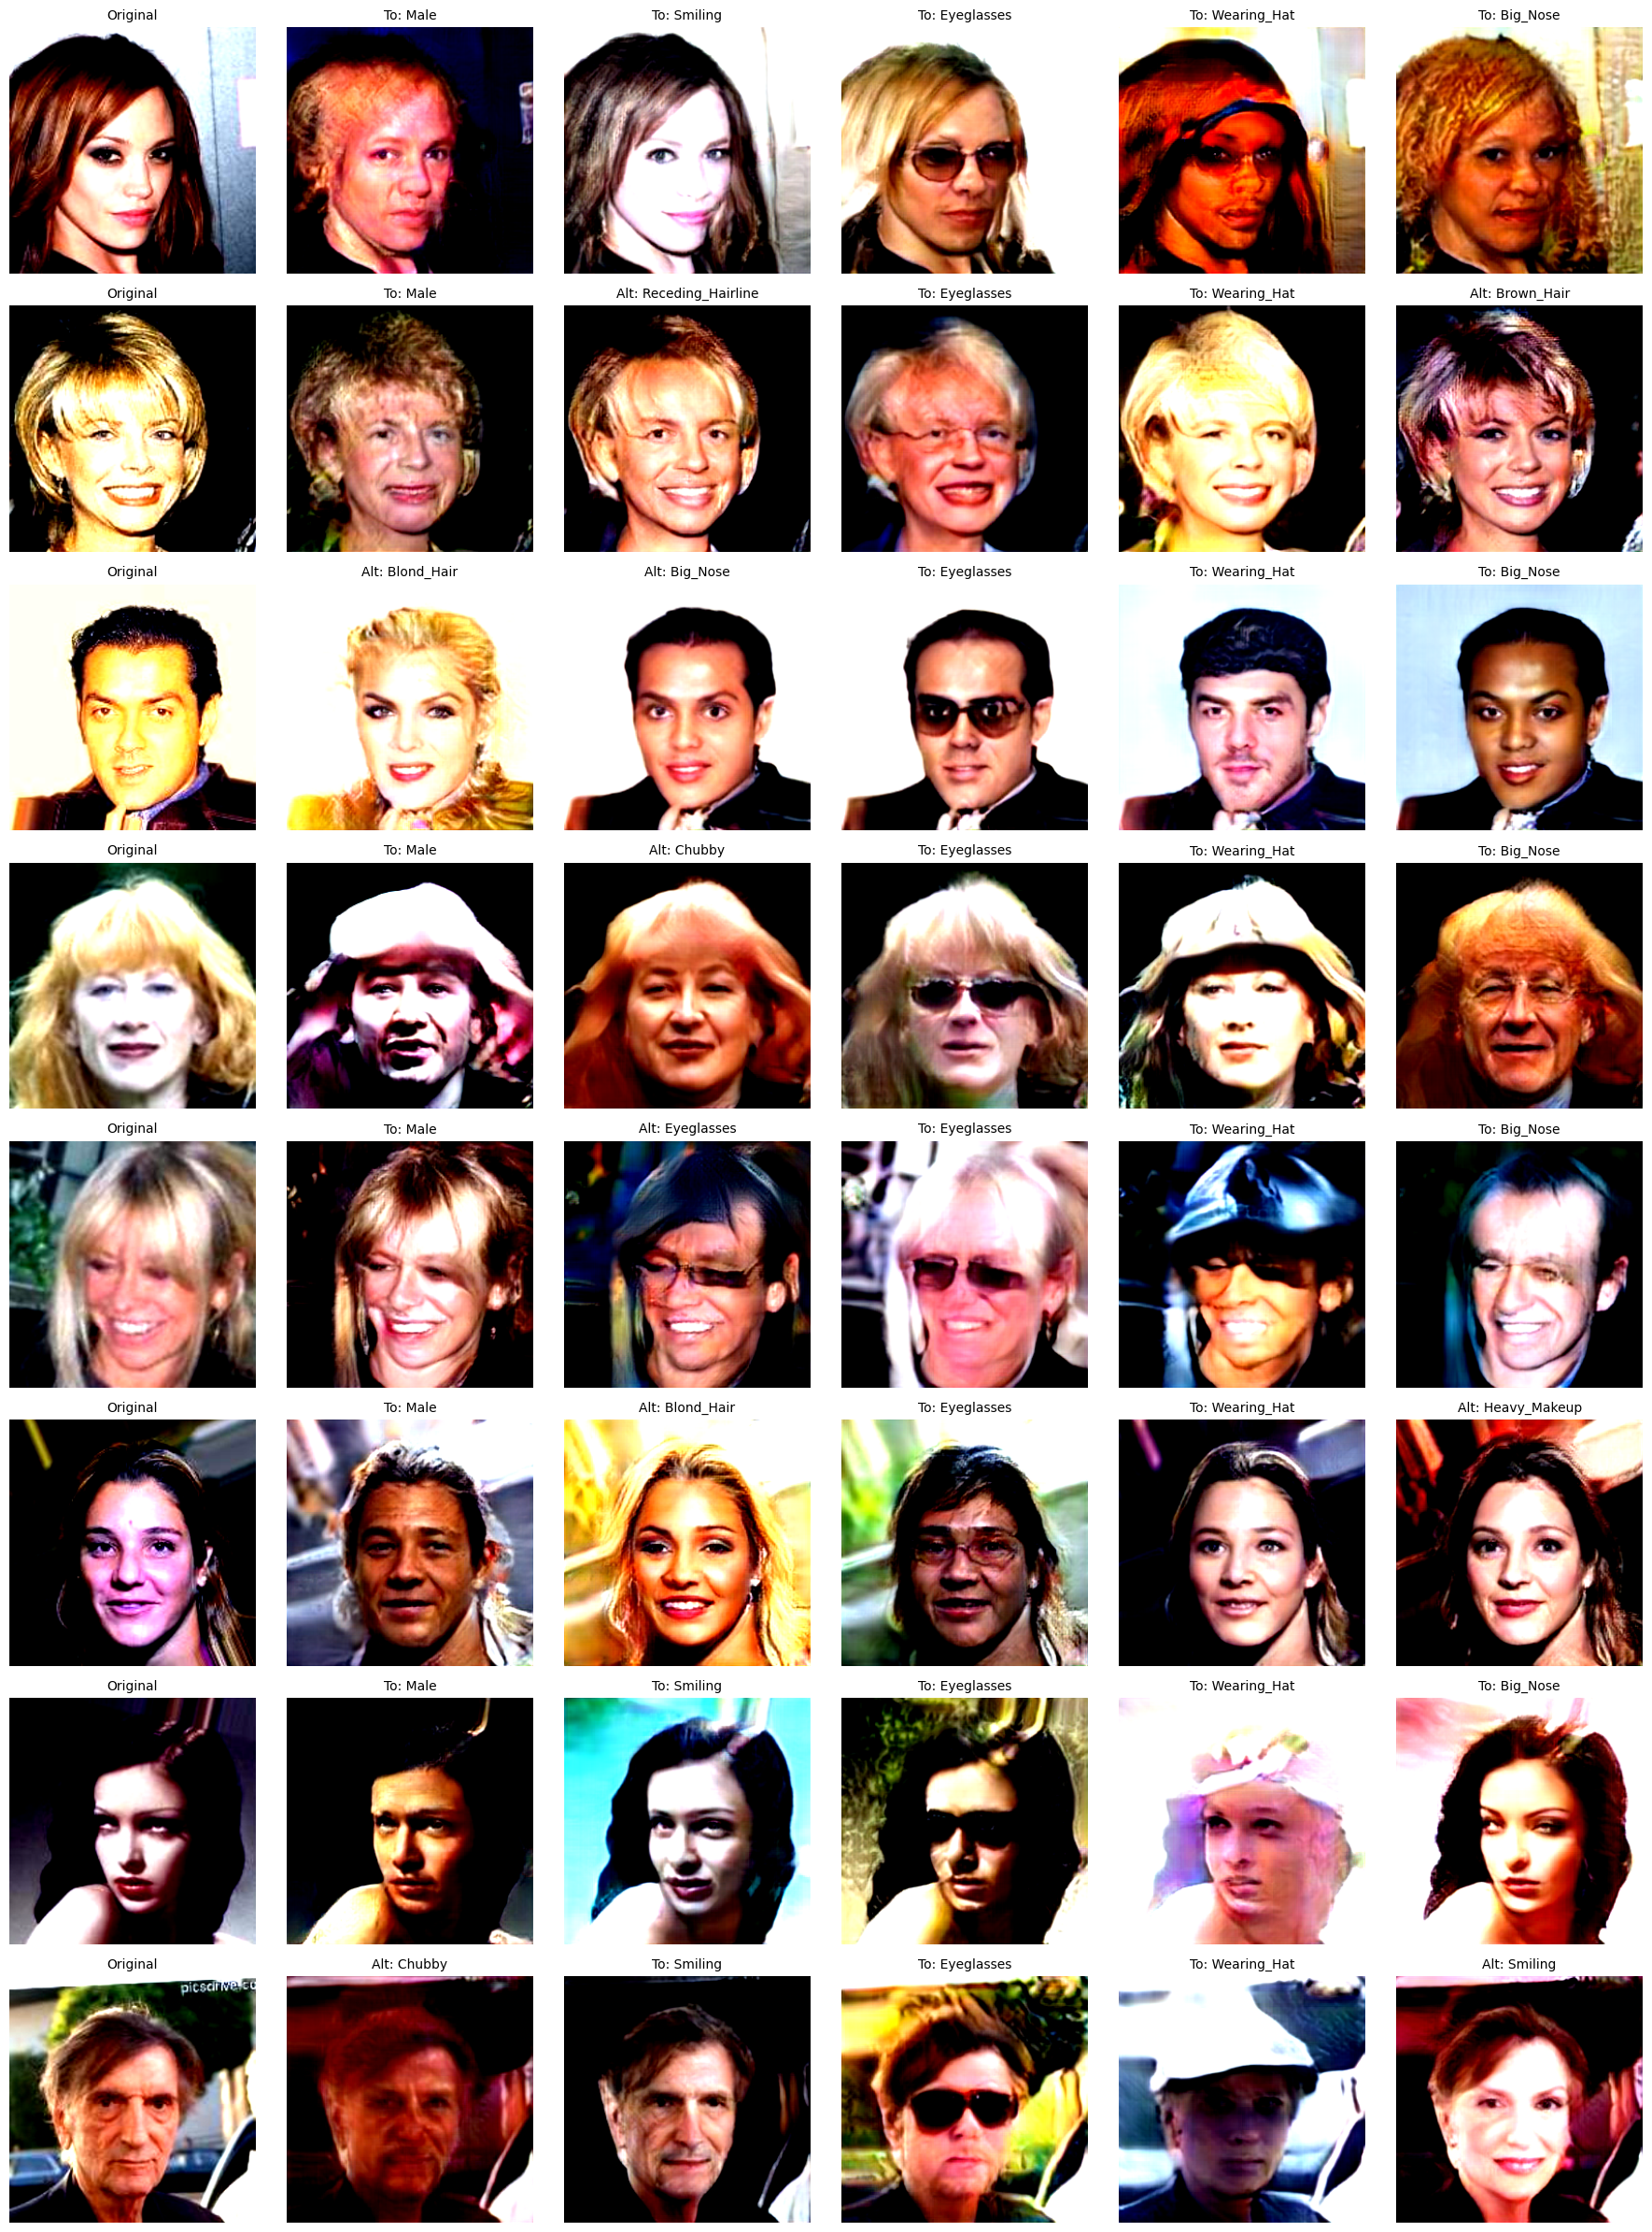

In [18]:
def visualize_results(nets_ema, dataloader, device, args, num_images=4):
    '''
    Функция для визуализации работы SatrGANv2 (тут был немного вайбкодинг в Google AI studio)
    Для реального изображения делаем image translation в другой домен (аттрибут в нашем случае)
    Например: female ---> male ---> wearing glasses -----> wearing hat
    При этом мы сделали так, чтобы аттрибут с оригинального изображения не повторялся в генерации новых изображений
    Dажно отметить, что для каждого изображения генерятся изображения с новыми атрибутами
    '''
    model_gen = nets_ema.generator
    model_map = nets_ema.mapping_network
    
    model_gen.eval()
    model_map.eval()

    x_real, y_org_multi = next(iter(dataloader))
    x_real = x_real.to(device).float()
    
    target_domains = [0, 2, 3, 4, 11] 
    
    fig, axes = plt.subplots(num_images, len(target_domains) + 1, figsize=(18, num_images * 3))

    with torch.no_grad():
        for i in range(num_images):

            img_orig = (x_real[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5
            axes[i, 0].imshow(np.clip(img_orig, 0, 1))
            axes[i, 0].set_title("Original", fontsize=10)
            axes[i, 0].axis('off')

            for j, trg_idx in enumerate(target_domains):
                actual_trg_idx = trg_idx
                
                if y_org_multi[i][trg_idx] == 1:
                    missing_attrs = torch.where(y_org_multi[i] == -1)[0].cpu().numpy()
                    actual_trg_idx = int(np.random.choice(missing_attrs))
                    title_prefix = "Alt: "
                else:
                    title_prefix = "To: "

                z_trg = torch.randn((1, args.latent_dim)).to(device)
                y_trg = torch.tensor([actual_trg_idx]).to(device)
                
                s_trg = model_map(z_trg, y_trg)
                x_fake = model_gen(x_real[i:i+1], s_trg)

                img_fake = (x_fake[0].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5
                axes[i, j+1].imshow(np.clip(img_fake, 0, 1))
                
                attr_name = selected_attrs[actual_trg_idx] if 'selected_attrs' in globals() else f"D {actual_trg_idx}"
                axes[i, j+1].set_title(f"{title_prefix}{attr_name}", fontsize=10)
                axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(nets_ema, dataloader, device, args, num_images=8)

## Этап 3. Дополнительный анализ

В данном разделе рекомендуется провести дополнительные эксперименты и анализ:
- **Анализ латентного пространства**. *(2 балла)*
- **Текстовое ревью решения**: опишите, какие изменения можно внести для улучшения модели, и обоснуйте их. *(1 балл)*

### Анализ латентного пространства

Сперва попробуем взять два случайных вектора $z_1, z_2$ и посмотрим как будет менятьпереход от одного к другому

torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])


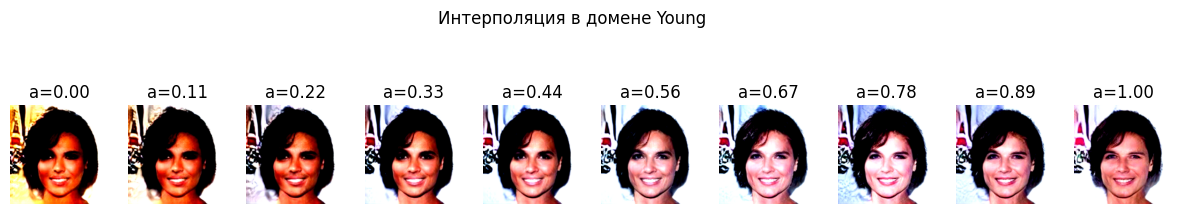

In [19]:
@torch.no_grad()
def analyze_latent_interpolation(nets_ema, x_real, args, domain_idx=2, steps=10):
    nets_ema.generator.eval()
    nets_ema.mapping_network.eval()
    
    x_src = x_real[0:1].to(device)
    z1 = torch.randn(1, args.latent_dim).to(device)
    z2 = torch.randn(1, args.latent_dim).to(device)
    y_trg = torch.tensor([domain_idx]).to(device)

    plt.figure(figsize=(15, 3))
    
    for i, alpha in enumerate(np.linspace(0, 1, steps)):
        z_interp = torch.lerp(z1, z2, alpha)
        
        s_trg = nets_ema.mapping_network(z_interp, y_trg)
        print(s_trg.shape)
        x_fake = nets_ema.generator(x_src, s_trg)
        
        img = (x_fake[0].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5
        plt.subplot(1, steps, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"a={alpha:.2f}")
        plt.axis('off')
    
    plt.suptitle(f"Интерполяция в домене {selected_attrs[domain_idx]}")
    plt.show()

x_real, _ = next(iter(dataloader))
analyze_latent_interpolation(nets_ema, x_real, args, domain_idx=1)

#### $\textbf{Короткий вывод:}$

В целом все выглядит неплохо, мы видим, что переход достаточно гладкий. Тут мы используем mapping network и смотрим как хорошо в одном и том же домене мы переходим от одного лица, к другому.

Лица получились отличными друг от друга, а значит генеартор тоже сработал неплохо.


Запуск t-SNE (это может занять пару минут)...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


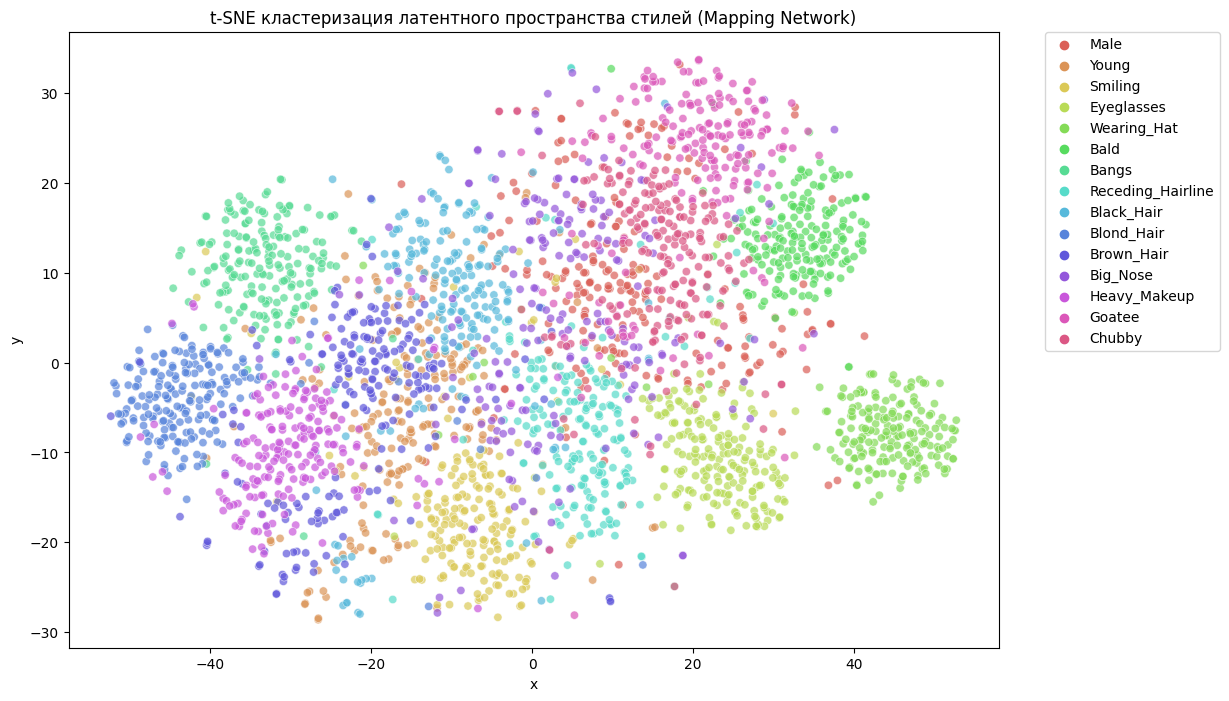

In [20]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

@torch.no_grad()
def analyze_tsne_styles(nets_ema, args, num_samples_per_domain=200):
    nets_ema.mapping_network.eval()
    
    styles_list = []
    labels_list = []
    
    for d_idx in range(args.num_domains):
        z = torch.randn(num_samples_per_domain, args.latent_dim).to(device)
        y = torch.full((num_samples_per_domain,), d_idx).to(device).long()
        
        s = nets_ema.mapping_network(z, y) # (B, style_dim)
        
        styles_list.append(s.cpu().numpy())
        labels_list.extend([selected_attrs[d_idx]] * num_samples_per_domain)
        
    all_styles = np.concatenate(styles_list, axis=0)
    
    print("Запуск t-SNE (это может занять пару минут)...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(all_styles)
    
    df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'label': labels_list
    })
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='x', y='y',
        hue='label',
        palette=sns.color_palette("hls", args.num_domains),
        data=df,
        legend="full",
        alpha=0.7
    )
    plt.title(f"t-SNE кластеризация латентного пространства стилей (Mapping Network)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

analyze_tsne_styles(nets_ema, args)

#### $\textbf{Короткий вывод:}$

1. Видно, что некоторые домены мешаются с другими, например Young и Smile, или большое количество мэйкапа и щетина (goatee). Такие пересечения кажутся логичными, так как нашей не самой тяжелой сетке было тяжеловато различать такие домены (например щетина и мэйкап могут имень схожую структуры, так как и это, и это находиться на лице, как правило в районе губ)

2. Но также важно сказать, что некоторые класетры видно очень четко и обособлено, что радует, то есть модель понимает, где находится некоторые кластеры, при этом почти между всеми достаточно плвный переход, что такде сведетельствует о неплохом обучении.

### Текстовое ревью решения

1. Начнем с минусов. Я сильно уменьшил размер латентного простраснтва, также размер сверток по сравнению с оригинальной статьей. Также мне пришлось оптимизировать код, чтобы уложиться в 10-12 часов обучения на 4 эпохах. Для это я добавил r1 регуляризацию, но сделал так чтобы считалась она не каждую иттерацию, а раз в 16 иттераций (иначе обучение занимало слишком много памяти), пришлось оптимизировать код с помощью обертки ```torch.cuda.amp```, это не повлияло на обучение, смещаная точность здесь помогла уменьшить затраты на память. Если бы обладал большими ресурсами и временем, то обучил бы больше эпох, батч сайз бы не трогал (обучал на 64 батч сайзе), но точно повысил бы до float32, чтобы стабилизировать обучение.

2. Чтобы было нелохо, но я бы улучшил: Сама сеть было очень хорошей, постарлся реализовать по максимум того, что понял из оригинальной статьи и кода, тут вроже сильно улучшить не выйдет